# <center><font color=navy>Time Series Forecasting</font></center>

<center> Taher Gari</center><center> Fahad Syed</center><center> Het Bhatt</center>

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import warnings
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.stats import boxcox
from pandas import Grouper
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [3]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(15, 6))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

### Importing the Time-Series Data

In [4]:
data=pd.read_csv('GlobalSuperstore.csv')

In [5]:
data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.65,762.18
1,5/2/2013,Corporate,APAC,3709.39,-288.76
2,17-10-2013,Consumer,APAC,5175.17,919.97
3,28-01-2013,Home Office,EU,2892.51,-96.54
4,5/11/2013,Consumer,Africa,2832.96,311.52


In [6]:
# checking the shape of the data
data.shape

(51290, 5)

###### There are 51290 rows and 5 columns in the data

In [7]:
# Summary of the Dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [8]:
# Statistical Details of the Dataframe
data.describe()

,Sales,Profit
count,51290.00,51290.00
mean,246.49,28.61
std,487.57,174.34
min,0.44,-6599.98
25%,30.76,0.00
50%,85.05,9.24
75%,251.05,36.81
max,22638.48,8399.98


In [9]:
data.nunique()

Order Date     1430
Segment           3
Market            7
Sales         22995
Profit        24575
dtype: int64

As we can see there are 3 types of Segments and 7 types of Market.
In total we have 21 unique Market-Segment types

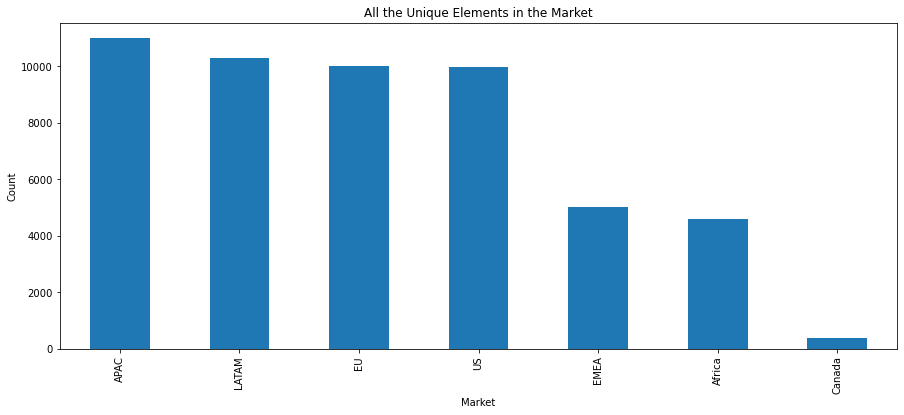

In [10]:
data['Market'].value_counts().plot(kind='bar')
plt.xlabel('Market')
plt.ylabel('Count')
plt.title('All the Unique Elements in the Market')
plt.show()

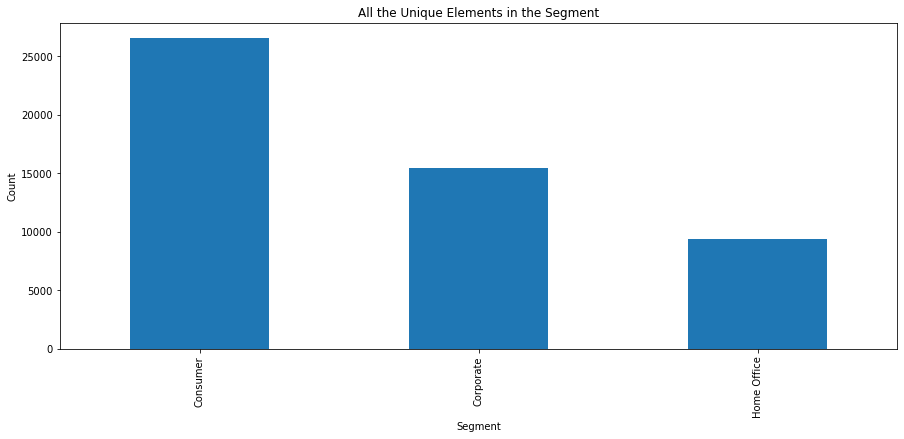

In [11]:
data['Segment'].value_counts().plot(kind='bar')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.title('All the Unique Elements in the Segment')
plt.show()

In [12]:
# Checking for the Null Values 
data.isnull().sum()

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

We can see that there are no null values

### Data Preparation

Creating a new column Market_Segment for 21 unique Market Segments 
by combining the respective 7 geographical markets for each of 3 segments.

In [13]:
data['Market_Segment']=data['Market']+'_'+data['Segment']

In [14]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
0,31-07-2012,Consumer,US,2309.65,762.18,US_Consumer
1,5/2/2013,Corporate,APAC,3709.39,-288.76,APAC_Corporate
2,17-10-2013,Consumer,APAC,5175.17,919.97,APAC_Consumer
3,28-01-2013,Home Office,EU,2892.51,-96.54,EU_Home Office
4,5/11/2013,Consumer,Africa,2832.96,311.52,Africa_Consumer


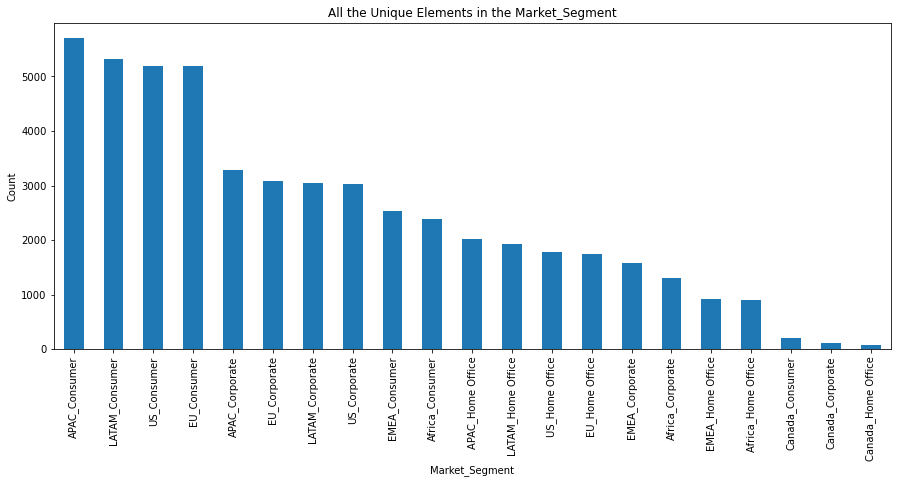

In [15]:
data['Market_Segment'].value_counts().plot(kind='bar')
plt.xlabel('Market_Segment')
plt.ylabel('Count')
plt.title('All the Unique Elements in the Market_Segment')
plt.show()

In [16]:
data['Market_Segment'].unique()

array(['US_Consumer', 'APAC_Corporate', 'APAC_Consumer', 'EU_Home Office',
       'Africa_Consumer', 'US_Corporate', 'EMEA_Consumer',
       'LATAM_Home Office', 'EU_Corporate', 'EMEA_Corporate',
       'LATAM_Consumer', 'EU_Consumer', 'US_Home Office',
       'LATAM_Corporate', 'Africa_Corporate', 'APAC_Home Office',
       'EMEA_Home Office', 'Africa_Home Office', 'Canada_Corporate',
       'Canada_Home Office', 'Canada_Consumer'], dtype=object)

In [17]:
# Converting order-date into a date-time format for getting it into the Month-year
data['Order Date'] = pd.to_datetime(data['Order Date']).dt.to_period('m')

In [18]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
0,2012-07,Consumer,US,2309.65,762.18,US_Consumer
1,2013-05,Corporate,APAC,3709.39,-288.76,APAC_Corporate
2,2013-10,Consumer,APAC,5175.17,919.97,APAC_Consumer
3,2013-01,Home Office,EU,2892.51,-96.54,EU_Home Office
4,2013-05,Consumer,Africa,2832.96,311.52,Africa_Consumer


In [19]:
data=data.sort_values(by=['Order Date'])

In [20]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
15262,2011-01,Corporate,EU,139.65,15.30,EU_Corporate
26744,2011-01,Consumer,EU,88.44,15.84,EU_Consumer
48614,2011-01,Corporate,EU,11.43,4.11,EU_Corporate
9417,2011-01,Consumer,LATAM,491.00,122.70,LATAM_Consumer
48590,2011-01,Home Office,US,4.71,0.00,US_Home Office


In [21]:
data=data.reset_index(drop=True)

In [22]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
0,2011-01,Corporate,EU,139.65,15.30,EU_Corporate
1,2011-01,Consumer,EU,88.44,15.84,EU_Consumer
2,2011-01,Corporate,EU,11.43,4.11,EU_Corporate
3,2011-01,Consumer,LATAM,491.00,122.70,LATAM_Consumer
4,2011-01,Home Office,US,4.71,0.00,US_Home Office


In [23]:
# We will create a pivot with each of these Market-Segment categories and this will be our new data
data_new=data.pivot_table( index='Order Date',values='Profit', columns='Market_Segment',aggfunc='sum')

In [24]:
data_new.head()

Market_Segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.49,-173.73,230.27,265.54,520.03,391.51,447.33,12.57,nan,-2952.59,...,392.53,2259.87,841.39,2534.57,540.44,1021.06,-26.60,2465.84,643.37,1233.93
2011-02,4627.85,3600.78,617.54,-201.89,-31.69,825.61,26.43,9.24,87.99,464.16,...,368.07,-783.99,2234.41,162.25,1227.87,814.03,-356.80,1853.55,421.93,553.95
2011-03,2337.83,3634.94,205.11,919.07,244.44,83.43,82.47,nan,84.03,706.38,...,-15.57,1273.71,2206.60,269.75,2427.40,178.66,769.88,204.20,127.47,-268.93
2011-04,633.64,90.75,603.85,381.31,941.75,417.62,55.08,6.51,nan,121.35,...,-456.51,2980.01,981.15,130.37,1368.83,872.64,-554.23,1434.86,494.73,2723.44
2011-05,3838.95,1028.45,102.03,-39.98,490.65,39.18,0.87,nan,nan,172.55,...,-33.59,673.01,1719.06,443.31,1749.39,134.87,-397.96,833.94,2912.80,145.78


### Train-Test Split

In [25]:
train_len = 42
train=data_new[0:train_len]
test=data_new[train_len:]

### Calculating the CoV on the profit for each of the 21 market segments on the train data

In [26]:
mean=np.mean(train)
std= np.std(train)

CoV= pd.DataFrame(mean)
CoV['std']= std
CoV['CoV'] = std/mean
CoV= CoV.reset_index()
CoV.columns= ['Market_Segment', 'Mean', 'Std', 'CoV']
CoV.sort_values(by='CoV', ascending= True, inplace = True)

In [27]:
CoV

,Market_Segment,Mean,Std,CoV
0,APAC_Consumer,4400.89,2300.46,0.52
1,APAC_Corporate,2574.92,1364.84,0.53
12,EU_Consumer,3699.98,2202.28,0.60
15,LATAM_Consumer,2295.56,1569.63,0.68
13,EU_Corporate,2216.30,1600.34,0.72
...,...,...,...,...
5,Africa_Home Office,377.22,759.32,2.01
8,Canada_Home Office,118.00,279.63,2.37
9,EMEA_Consumer,423.96,1124.55,2.65
10,EMEA_Corporate,182.64,1160.70,6.36


In [28]:
Lowest_CoV_value =min(CoV["CoV"])
Lowest_CoV_value

0.5227250555218101

we prefer lowest CoV is because we want to estimate sales for the most consistently profitable Market-Segment, so that our sales forecasts are reliable

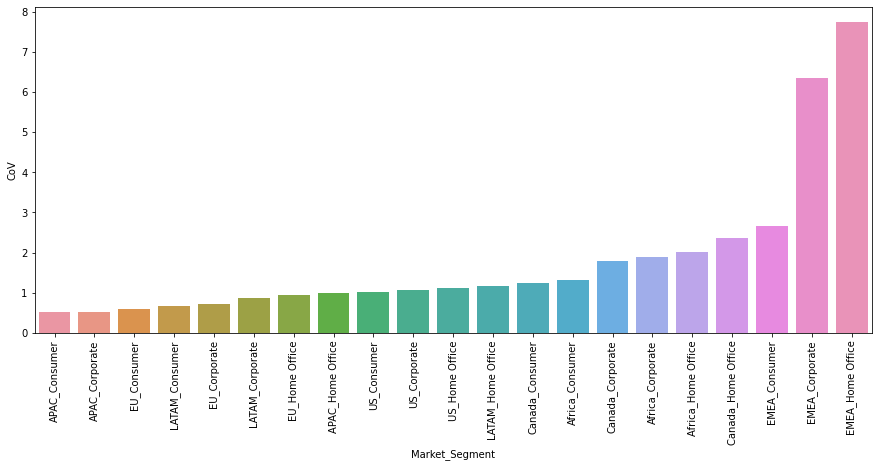

In [29]:
sns.barplot(data=CoV,x='Market_Segment',y='CoV')
plt.xticks(rotation=90)
plt.show()

In [30]:
data['Order Date'].dtype

period[M]

### Converting the Order-Date column from "DateTime" to "timestamp

In [31]:
data['Order Date']=data['Order Date'].astype(str)
data['Order Date']=pd.to_datetime(data['Order Date'])

In [32]:
data['Order Date'].dtype

dtype('<M8[ns]')

In [33]:
# extracting APAC_Consumer as it has the lowest CoV
data_final=data[data.Market_Segment=='APAC_Consumer']

In [34]:
data_final.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
13,2011-01-01,Consumer,APAC,1429.05,371.49,APAC_Consumer
23,2011-01-01,Consumer,APAC,219.78,59.34,APAC_Consumer
35,2011-01-01,Consumer,APAC,342.51,54.60,APAC_Consumer
37,2011-01-01,Consumer,APAC,102.76,1.84,APAC_Consumer
40,2011-01-01,Consumer,APAC,420.42,147.00,APAC_Consumer


In [35]:
data_final.drop(columns=['Segment', 'Market'],inplace=True)

In [36]:
data_final.head()

,Order Date,Sales,Profit,Market_Segment
13,2011-01-01,1429.05,371.49,APAC_Consumer
23,2011-01-01,219.78,59.34,APAC_Consumer
35,2011-01-01,342.51,54.60,APAC_Consumer
37,2011-01-01,102.76,1.84,APAC_Consumer
40,2011-01-01,420.42,147.00,APAC_Consumer


In [37]:
data_final.shape

(5699, 4)

In [38]:
data_final.groupby('Order Date')['Sales'].sum()

Order Date
2011-01-01   18821.99
2011-02-01   23313.35
2011-03-01   26518.49
2011-04-01   12046.09
2011-05-01   25941.90
               ...   
2014-08-01   48848.34
2014-09-01   45424.31
2014-10-01   61221.98
2014-11-01   79834.43
2014-12-01   57099.99
Name: Sales, Length: 48, dtype: float64

In [39]:
data_final_sales=pd.DataFrame(data_final.groupby('Order Date')['Sales'].sum())

In [40]:
data_final_sales.head()

,Sales
Order Date,
2011-01-01,18821.99
2011-02-01,23313.35
2011-03-01,26518.49
2011-04-01,12046.09
2011-05-01,25941.90


In [41]:
data_final_sales.shape

(48, 1)

### Time Series Analysis

In [42]:
# Plotting the time series data

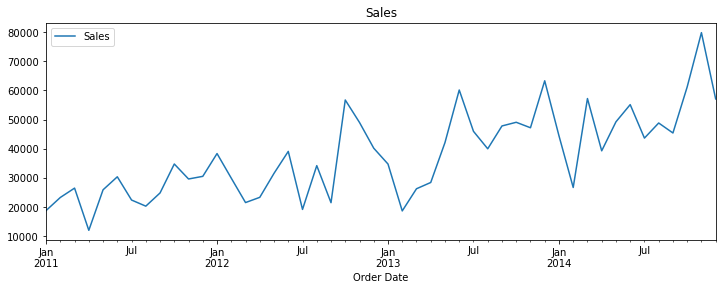

In [43]:
data_final_sales.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

In [44]:
data_final_sales.isnull().sum()

Sales    0
dtype: int64

There are no null values

### Splitting time series data into training and test set

In [45]:
train_len = 42
train=data_final_sales[0:train_len]
test=data_final_sales[train_len:] 

In [46]:
train.shape

(42, 1)

In [47]:
test.shape

(6, 1)

In [48]:
train.head()

,Sales
Order Date,
2011-01-01,18821.99
2011-02-01,23313.35
2011-03-01,26518.49
2011-04-01,12046.09
2011-05-01,25941.90


In [49]:
test.head()

,Sales
Order Date,
2014-07-01,43672.07
2014-08-01,48848.34
2014-09-01,45424.31
2014-10-01,61221.98
2014-11-01,79834.43


## Time Series Decomposition

#### Additive seasonal decomposition

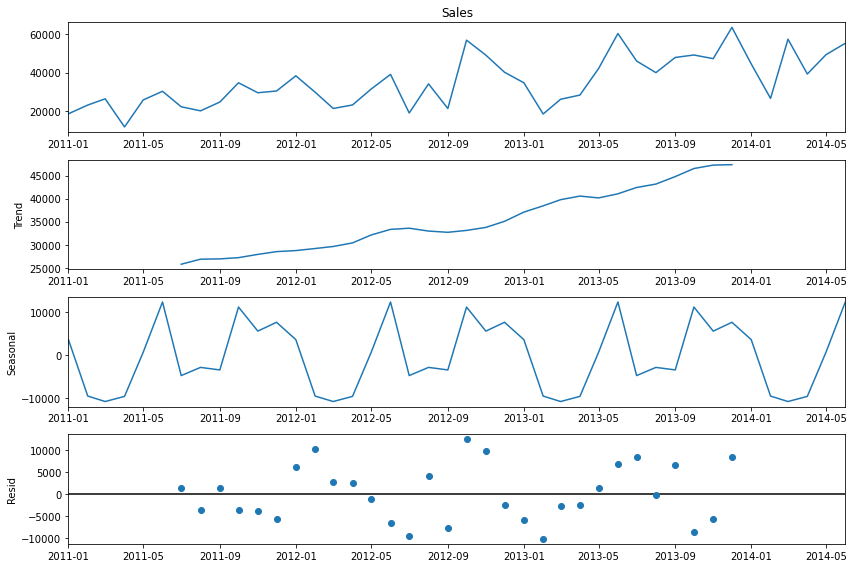

In [50]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

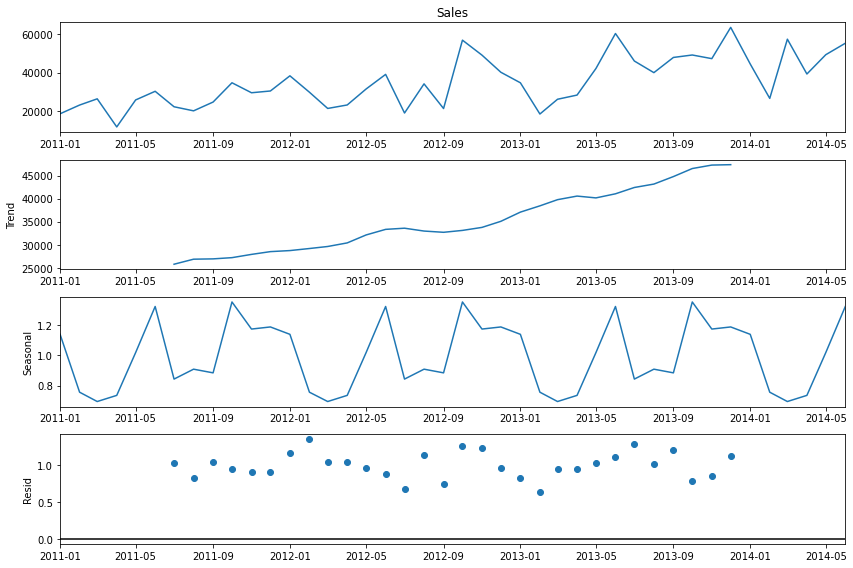

In [51]:
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

With more than 10 observations depicting a clear upward Trend and Seasonality

### Simple exponential smoothing

In [52]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6) #alpha=0

#### Plot train, test and forecast

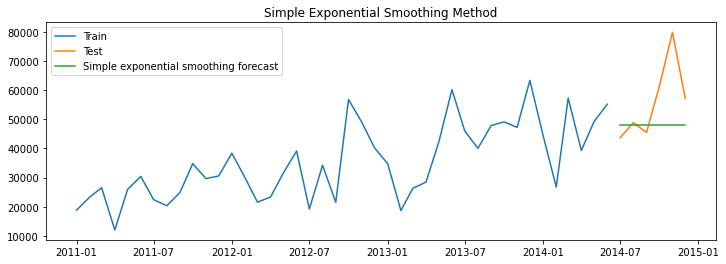

In [53]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [54]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

results=pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74


# Auto Regressive methods

### Stationarity vs non-stationary time series

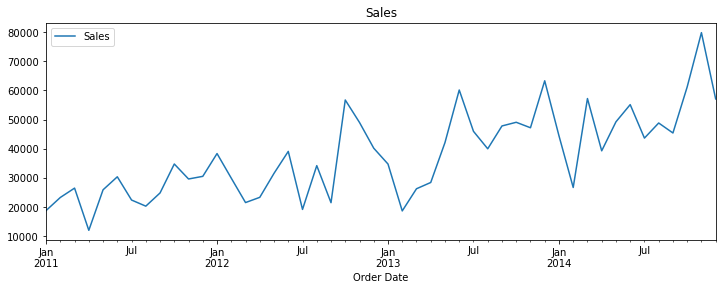

In [55]:
data_final_sales['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

#### Augmented Dickey-Fuller (ADF) test

Null Hypothesis  (H0) : The series is not stationary  p−value>0.05 


Alternate Hypothesis: (H1)  The series is stationary  p−value<=0.05

In [56]:
adf_test = adfuller(data_final_sales['Sales'])

In [57]:
adf_test

(-3.3760244736258036,
 0.011803859657119728,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 804.80930070885)

In [58]:
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.376024
Critical Values @ 0.05: -2.93
p-value: 0.011804


We can see that p-value is 0.011, which is less than 0.05

So The series is stationary. And Reject the null hypothesis

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

Null Hypothesis  (H0) : The series is stationary  p−value>0.05 


Alternate Hypothesis: (H1)  The series is not stationary  p−value<=0.05

In [59]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_final_sales['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.577076
Critical Values @ 0.05: 0.46
p-value: 0.024720


p-value is 0.024 < 0.05
Which means the series is not Stationary

### Box Cox transformation to make variance constant

In [60]:
data_boxcox = pd.Series(boxcox(data_final_sales['Sales'], lmbda=0), index = data_final_sales.index)

In [61]:
data_boxcox.head()

Order Date
2011-01-01    9.84
2011-02-01   10.06
2011-03-01   10.19
2011-04-01    9.40
2011-05-01   10.16
dtype: float64

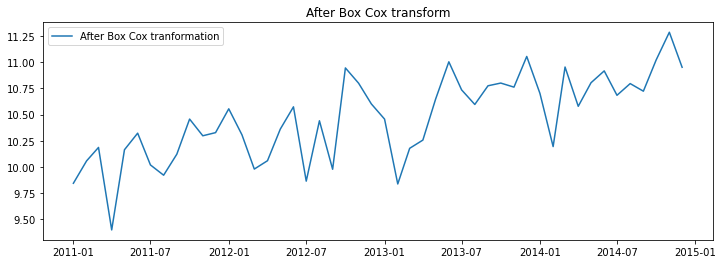

In [62]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

Box-Cox Transformation makes the variance constant in a Time series.

### Differencing to remove trend

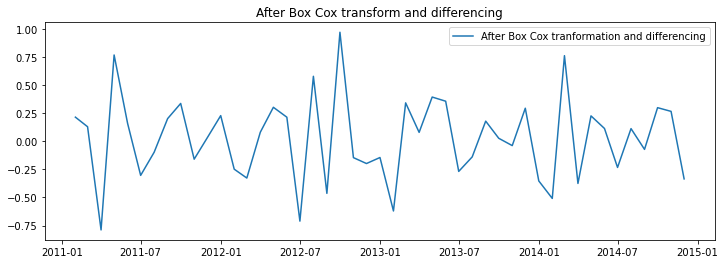

In [63]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data_final_sales.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [64]:
data_boxcox_diff

Order Date
2011-01-01     nan
2011-02-01    0.21
2011-03-01    0.13
2011-04-01   -0.79
2011-05-01    0.77
              ... 
2014-08-01    0.11
2014-09-01   -0.07
2014-10-01    0.30
2014-11-01    0.27
2014-12-01   -0.34
Length: 48, dtype: float64

The fluctuations are under constant limits


The mean is also centered around zero

In [65]:
data_boxcox_diff.dropna(inplace=True)

In [66]:
data_boxcox_diff.tail()

Order Date
2014-08-01    0.11
2014-09-01   -0.07
2014-10-01    0.30
2014-11-01    0.27
2014-12-01   -0.34
dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [67]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


p-value is 0.0001 < 0.05, Reject the null hypothesis  (H0) 

The series is stationary

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [68]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.156456
Critical Values @ 0.05: 0.46
p-value: 0.100000


p-value is 0.100 >= 0.05, Fail to reject the null hypothesis  (H0) 


The series is stationary

In [69]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

##### We will directly use p=1, q=1 and d=1 as the forecasts are relatively better for these values.

### Auto regression method (AR)

In [70]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.02
ar.L1.y   -0.41
dtype: float64


### Recover original time series

In [71]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

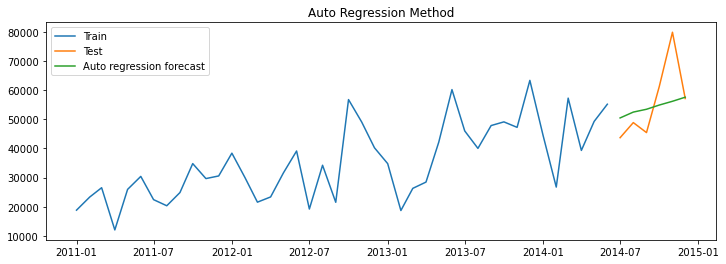

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [73]:
##### From the plot we can see that we are able to capture trend in the forecast but could not cature the seasonality

### Calculate RMSE and MAPE

In [74]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales']*100),2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Autoregressive (AR) method,10985.28,13.56


### Moving average method (MA)

In [75]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.02
ma.L1.y   -1.00
dtype: float64


### Recover original time series

In [76]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

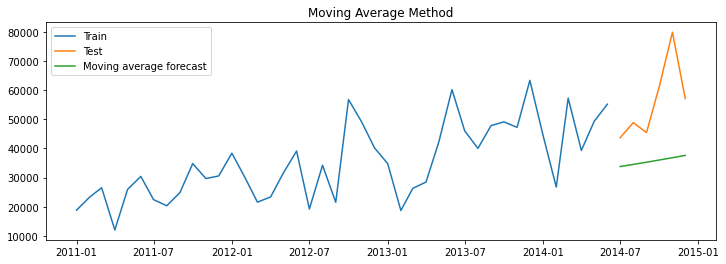

In [77]:
plt.figure(figsize=(12,4))
plt.plot(data_final_sales['Sales'][:train_len], label='Train')
plt.plot(data_final_sales['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [78]:
#### We are able to capture trend but not seasonality in the forecast

### Calculate RMSE and MAPE

In [79]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93


### Auto regression moving average method (ARMA)

In [80]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.02
ar.L1.y    0.07
ma.L1.y   -1.00
dtype: float64


### Recover original time series

In [81]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

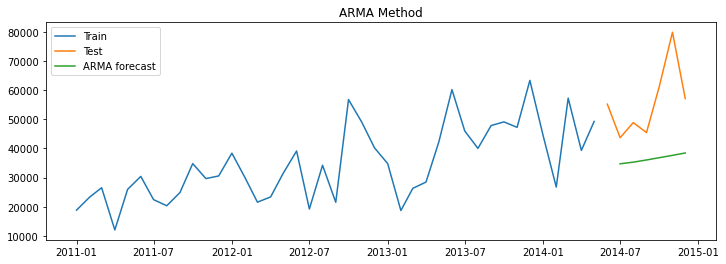

In [82]:
plt.figure(figsize=(12,4))
plt.plot( data_final_sales['Sales'][:train_len-1], label='Train')
plt.plot(data_final_sales['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [83]:
#### ARMA model captured Trend but no seasonality

### Calculate RMSE and MAPE

In [84]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


### Auto regressive integrated moving average (ARIMA)

In [85]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02
ar.L1.D.y    0.07
ma.L1.D.y   -1.00
dtype: float64


### Recover original time series forecast

In [86]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

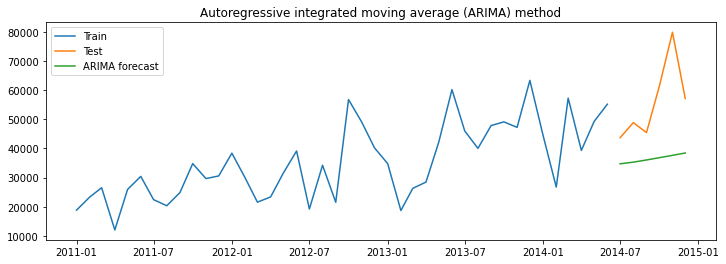

In [87]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [88]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40
0,Autoregressive integrated moving average (ARIM...,22654.32,32.40


### Seasonal auto regressive integrated moving average (SARIMA)

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.04
ma.L1      -1.00
ar.S.L12    0.10
ma.S.L12   -0.98
sigma2      0.06
dtype: float64


### Recover original time series forecast

In [90]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

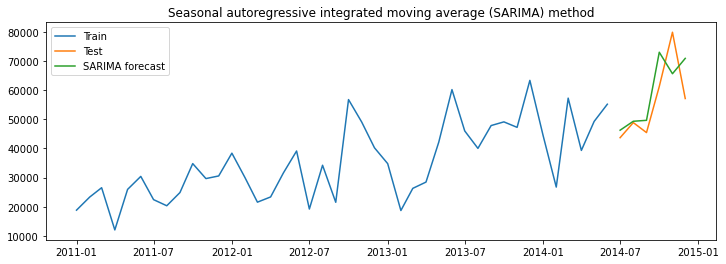

In [91]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [92]:
##### The forecast captured both trend and seasonality

### Calculate RMSE and MAPE

In [93]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40
0,Autoregressive integrated moving average (ARIM...,22654.32,32.40
0,Seasonal autoregressive integrated moving aver...,9615.81,12.87


Among all the methods done in the ARIMA above, we can conclude that forecast done using SARIMA method is able to predict the sales closer to the actual values

### Conclusion

SARIMA - Seasonal Autoregressive Integrated moving average is the best method in ARIMA set of techniques.